In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


import mpmath
import networkx as nx

from metal.label_model import LabelModel, LabelModelInd
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data

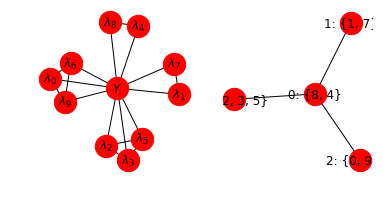

In [75]:
N = 1000 #not used
M = 10
K=2
N_CLUSTERS = M-5
EDGE_PROB = 1.0
HIGHER_ORDER_CLIQUES = False


deps_graph = ClusterDependencies(M, N_CLUSTERS, edge_prob=EDGE_PROB)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
deps_graph.draw()

data = DataGenerator(
    n=N,
    m=M,
    k=K,
    abstains=False,
    class_balance = [0.5, 0.5],
    deps_graph=deps_graph,
    param_ranges={
            "theta_acc_range": (0.1, 1),
            "theta_edge_range": (0.75, 1),
        },
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
plt.subplot(1,2,2)
data.jt.draw()

In [76]:
sigma_O = data.get_sigma_O()
E_O = np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
class_balance = data.get_class_balance()
class_balance

array([0.74252131, 0.25747869])

## Train LabelModel with Independent LF Assumption
Note we use the class balance since these are observable/we assume are known

In [77]:
#Create junction tree with no dependencies between LFs
edges_ind = []
for i in range(M):
    edges_ind.append((i,M))

jt_ind = JunctionTree(
            M,
            K,
            abstains=False,
            edges=edges_ind,
            higher_order_cliques=HIGHER_ORDER_CLIQUES
        )

#Train LabelModel
lm = LabelModel(k=K)
lm.train(
    sigma_O=sigma_O,
    E_O=E_O,
    junction_tree=jt_ind,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000
)

Estimating Z...
[E:0]	Train Loss: 78.33579254
[E:1000]	Train Loss: 0.00000000
[E:2000]	Train Loss: 0.00000000
[E:3000]	Train Loss: 0.00000000
[E:4000]	Train Loss: 0.00000000
[E:5000]	Train Loss: 0.00000000
[E:6000]	Train Loss: 0.00000000
[E:7000]	Train Loss: 0.00000000
[E:8000]	Train Loss: 0.00000000
[E:9000]	Train Loss: 0.00000000
[E:9999]	Train Loss: 0.00000000
Finished Training


In [78]:
mu = data.get_mu()
np.mean(np.abs(mu - lm.mu))

4.7153187077153545e-09

## Dependency Learning with RPCA

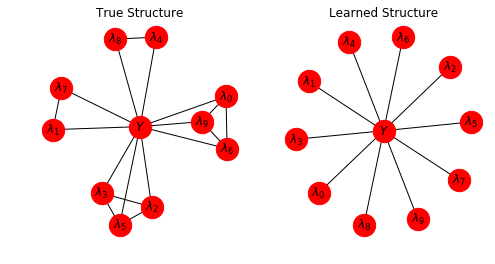

In [106]:
sigma_O_inv = np.linalg.inv(sigma_O)
dl = DependencyLearner(M,sigma_O_inv)
edges_est = dl.edges_from_amc(thresh=3e-1)
deps_graph_est = DependenciesGraph(M, edges_est)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('True Structure')
deps_graph.draw()
plt.subplot(1,2,2)
plt.title('Learned Structure')
deps_graph_est.draw()

In [95]:
for i in range(M):
    edges_est.append((i,M))

jt_est = JunctionTree(
            M,
            K,
            abstains=False,
            edges=edges_est,
            higher_order_cliques=HIGHER_ORDER_CLIQUES
        )

lm_deps = LabelModel(k=K)
lm_deps.train(
    sigma_O=sigma_O,
    E_O=E_O,
    junction_tree=jt_est,
    class_balance=class_balance,
    lr=0.01,
    n_epochs=10000,
    print_every=1000
)

Estimating Z...
[E:0]	Train Loss: 159.15982056
[E:1000]	Train Loss: 0.00000000
[E:2000]	Train Loss: 0.00000000
[E:3000]	Train Loss: 0.00000000
[E:4000]	Train Loss: 0.00000000
[E:5000]	Train Loss: 0.00000000
[E:6000]	Train Loss: 0.00000000
[E:7000]	Train Loss: 0.00000000
[E:8000]	Train Loss: 0.00000000
[E:9000]	Train Loss: 0.00000000
[E:9999]	Train Loss: 0.00000000
Finished Training


NotImplementedError: Sigma_H for non-singleton sep sets.

In [ ]:
mu = data.get_mu()
print ("Error with independence assumption: ", np.mean(np.abs(mu - lm.mu)))
print ("Error with dependency learning    : ", np.mean(np.abs(mu - lm_deps.mu)))